train autoencoder WITHOUT using 1DCNN roi finder

In [1]:
import sys
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle
from PyPDF2 import PdfMerger
import os
from tensorflow.keras.models import load_model
import preprocess_functs as pp

2023-05-19 22:18:00.714245: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-19 22:18:01.554530: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Load and split data

In [2]:
wireplane = "U"
np.random.seed(77)
path = '/home/vlian/Workspace/processed_ar39/'

In [3]:
dataset = np.load(path+'Sample_'+wireplane+'_Plane.npy', allow_pickle=True)

In [4]:
pp.group_num_labels_ar39

{0: 'adc_4_6',
 1: 'adc_7_9',
 2: 'adc_10_12',
 3: 'adc_13_15',
 4: 'adc_16_18',
 5: 'adc_19_21',
 6: 'adc_gt_21'}

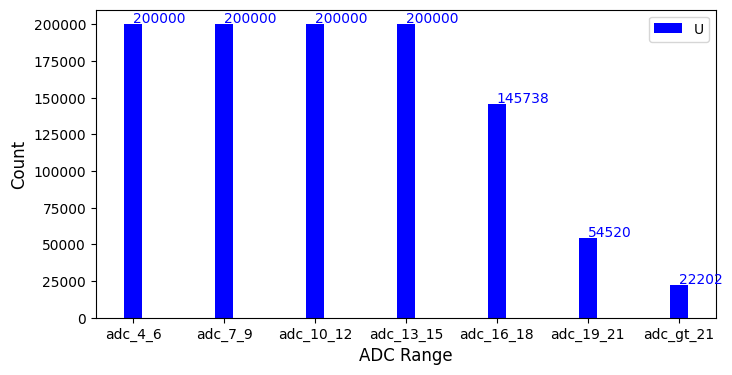

In [5]:
fig = plt.figure(figsize=(8,4))
x_labels = [pp.group_num_labels_ar39[i] for i in range(7)]
bar_width = 0.2

plt.bar([i for i in range(7)], dataset[1], width=bar_width, color='blue', label=wireplane)

for i in range(7):
    dist = 1000
    plt.text(i, dataset[1][i] + dist, dataset[1][i], color='blue', size=10)

plt.xticks([i for i in range(7)], x_labels)
plt.legend()
plt.xlabel('ADC Range', size=12)
plt.ylabel('Count', size=12)
plt.show()

### get additonal samples for adc_gt_21 from NU_CC and NU_ES

In [6]:
path = '/home/vlian/Workspace/train_dune_lartpc_v2/'
nticks = 200
ADC_MIN = 15
signal_waveforms, clean_signal_waveforms, noise_waveforms, noiseless_waveform = pp.process_data(wireplane=wireplane, path=path, ADC_MIN=ADC_MIN)

for i in range(10):
    signal_waveforms, clean_signal_waveforms = shuffle(signal_waveforms, clean_signal_waveforms)

nu_cc:  /home/vlian/Workspace/train_dune_lartpc_v2/nu_cc/
nu_es:  /home/vlian/Workspace/train_dune_lartpc_v2/nu_es/
noise:  /home/vlian/Workspace/train_dune_lartpc_v2/noise/

----------loading----------
--------data loaded!-------
---------------------------------
     signal+noise:  218916
     clean signal:  218916
     noise       :  100000
---------------------------------

filtering out small signals --> ADC > 15
     noise+signal :  (218916, 200)
     clean signal :  (218916, 200)
------------after filtering------------
     noise+signal :  (88644, 200)
     clean signal :  (88644, 200)


In [7]:
nu_es_cc_grouped_by_ADC = pp.adc_grouping(signal_waveforms, clean_signal_waveforms)
nu_es_cc_grouped_by_ADC = np.array(nu_es_cc_grouped_by_ADC, dtype=object)
for_combining = nu_es_cc_grouped_by_ADC[:, :7]

 0: adc_4_6             1: adc_7_9             2: adc_10_12             3: adc_13_15             4: adc_16_18             5: adc_19_21             6: adc_gt_21            7: noise

adc_4_6
count       0

adc_6_9
count       0

adc_10_12
count       0

adc_13_15
count       0

adc_16_18
count       5250

adc_19_21
count       4573

adc_gt_21
count       78821

noise
count       0

     Total:    88644


In [8]:
print(dataset.shape, for_combining.shape)

(2, 7) (2, 7)


In [9]:
waves_idx = 0
count_idx = 1
x_idx = 0
y_idx= 1

adc_group_idx = 0

# dataset[waves_idx][adc_group_idx][x_idx]

In [10]:
print(type(dataset[waves_idx][adc_group_idx][x_idx]),
            type(for_combining[waves_idx][adc_group_idx][x_idx]))

<class 'list'> <class 'list'>


In [11]:
print(len(dataset[waves_idx][adc_group_idx][x_idx]),
            len(for_combining[waves_idx][adc_group_idx][x_idx]))

200000 0


In [12]:
# sudo code
for adc_group_idx in range(7):
    if len(for_combining[waves_idx][adc_group_idx][x_idx]) > 0:
        dataset[waves_idx][adc_group_idx][x_idx] += for_combining[waves_idx][adc_group_idx][x_idx]
        dataset[waves_idx][adc_group_idx][y_idx] += for_combining[waves_idx][adc_group_idx][y_idx]
        
        dataset[count_idx][adc_group_idx] += len(for_combining[waves_idx][adc_group_idx][x_idx])
        dataset[count_idx][adc_group_idx] += len(for_combining[waves_idx][adc_group_idx][y_idx])




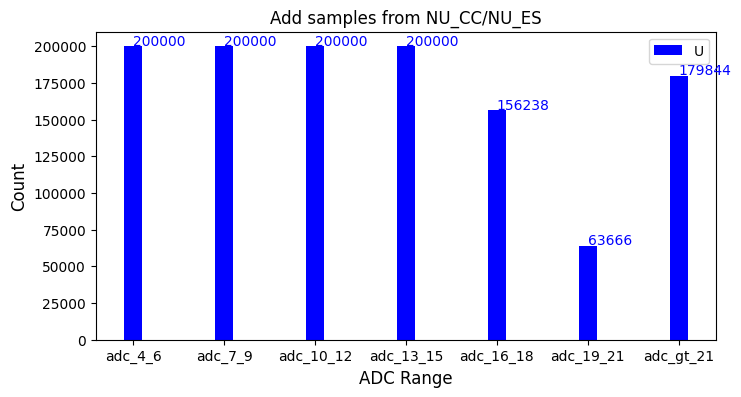

In [13]:
fig = plt.figure(figsize=(8,4))
x_labels = [pp.group_num_labels_ar39[i] for i in range(7)]
bar_width = 0.2

plt.bar([i for i in range(7)], dataset[1], width=bar_width, color='blue', label=wireplane)
plt.title('Add samples from NU_CC/NU_ES')

for i in range(7):
    dist = 1000
    plt.text(i, dataset[1][i] + dist, dataset[1][i], color='blue', size=10)

plt.xticks([i for i in range(7)], x_labels)
plt.legend()
plt.xlabel('ADC Range', size=12)
plt.ylabel('Count', size=12)
plt.show()

In [14]:
adc_group_idx = 0
adc_4_6_x = [dataset[waves_idx][adc_group_idx][x_idx][i] for i in range(50000)]
adc_4_6_y = [dataset[waves_idx][adc_group_idx][y_idx][i] for i in range(50000)]

In [15]:
adc_5_6_x = []
adc_5_6_y = []

for i, wave in enumerate(adc_4_6_y):
    if len(adc_5_6_x) >= 25000:
        break
    if max(abs(wave)) > 4:
        adc_5_6_x.append(adc_4_6_x[i])
        adc_5_6_y.append(wave)

In [16]:
print(len(adc_5_6_x), len(adc_5_6_y))

25000 25000


In [17]:
a = [i for i in adc_4_6_y if max(abs(i)) == 6]

In [18]:
len(a)

15363

In [19]:
adc_group_idx = 1
adc_7_9_x = [dataset[waves_idx][adc_group_idx][x_idx][i] for i in range(25000)]
adc_7_9_y = [dataset[waves_idx][adc_group_idx][y_idx][i] for i in range(25000)]

adc_group_idx = 2
adc_10_12_x = [dataset[waves_idx][adc_group_idx][x_idx][i] for i in range(25000)]
adc_10_12_y = [dataset[waves_idx][adc_group_idx][y_idx][i] for i in range(25000)]

adc_group_idx = 3
adc_13_15_x = [dataset[waves_idx][adc_group_idx][x_idx][i] for i in range(25000)]
adc_13_15_y = [dataset[waves_idx][adc_group_idx][y_idx][i] for i in range(25000)]

In [20]:
dataset_to_train_small_adc_x = adc_5_6_x + adc_7_9_x + adc_10_12_x + adc_13_15_x
dataset_to_train_small_adc_y = adc_5_6_y + adc_7_9_y + adc_10_12_y + adc_13_15_y

In [21]:
dataset_to_train_small_adc_grouping = pp.adc_grouping(dataset_to_train_small_adc_x, dataset_to_train_small_adc_y)

 0: adc_4_6             1: adc_7_9             2: adc_10_12             3: adc_13_15             4: adc_16_18             5: adc_19_21             6: adc_gt_21            7: noise

adc_4_6
count       25000

adc_6_9
count       25000

adc_10_12
count       25000

adc_13_15
count       25000

adc_16_18
count       0

adc_19_21
count       0

adc_gt_21
count       0

noise
count       0

     Total:    100000


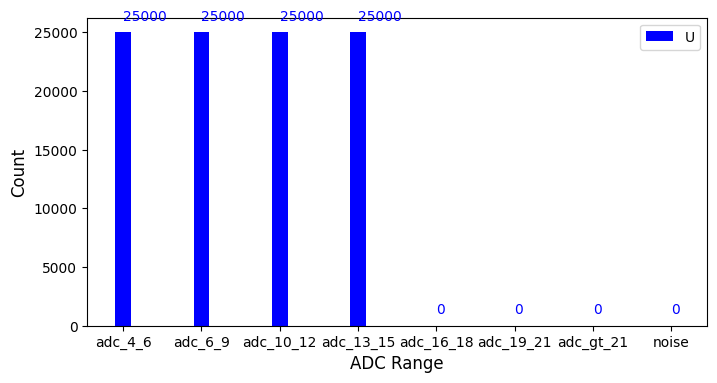

In [22]:
fig = plt.figure(figsize=(8,4))
x_labels = [pp.group_num_labels[i] for i in range(8)]
bar_width = 0.2

plt.bar([i for i in range(8)], dataset_to_train_small_adc_grouping[1], width=bar_width, color='blue', label=wireplane)

for i in range(8):
    dist = 1000
    plt.text(i, dataset_to_train_small_adc_grouping[1][i] + dist, dataset_to_train_small_adc_grouping[1][i], color='blue', size=10)

plt.xticks([i for i in range(8)], x_labels)
plt.legend()
plt.xlabel('ADC Range', size=12)
plt.ylabel('Count', size=12)
plt.show()

In [23]:
print(len(dataset_to_train_small_adc_x), len(dataset_to_train_small_adc_y))

100000 100000


In [24]:
for i in range(10):
    dataset_to_train_small_adc_x, dataset_to_train_small_adc_y = shuffle(dataset_to_train_small_adc_x, dataset_to_train_small_adc_y)

In [25]:
dataset_to_train_small_adc_x_train, dataset_to_train_small_adc_x_test, dataset_to_train_small_adc_y_train, dataset_to_train_small_adc_y_test = train_test_split(dataset_to_train_small_adc_x, dataset_to_train_small_adc_y, test_size=0.5, shuffle=True)

In [26]:
x_noise_train, x_noise_test, y_noise_train, y_noise_test = train_test_split(noise_waveforms, noiseless_waveform, test_size=0.5, shuffle=True)

In [27]:
for i in range(10):
    dataset_to_train_small_adc_x_train, dataset_to_train_small_adc_y_train = shuffle(dataset_to_train_small_adc_x_train, dataset_to_train_small_adc_y_train)
    dataset_to_train_small_adc_x_test, dataset_to_train_small_adc_y_test = shuffle(dataset_to_train_small_adc_x_test, dataset_to_train_small_adc_y_test)
    x_noise_train, y_noise_train = shuffle(x_noise_train, y_noise_train)
    x_noise_test, y_noise_test = shuffle(x_noise_test, y_noise_test)

In [28]:
x_train = np.concatenate((dataset_to_train_small_adc_x_train, x_noise_train))
y_train = np.concatenate((dataset_to_train_small_adc_y_train, y_noise_train))

x_test = np.concatenate((dataset_to_train_small_adc_x_test, x_noise_test))
y_test = np.concatenate((dataset_to_train_small_adc_y_test, y_noise_test))

In [29]:
for i in range(10):
    x_train, y_train = shuffle(x_train, y_train)
    x_test, y_test = shuffle(x_test, y_test)

### training validation split

In [30]:
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=0.2, shuffle=False
)

In [31]:
train_set = pp.adc_grouping(x_train, y_train)
test_set = pp.adc_grouping(x_test, y_test)
val_set = pp.adc_grouping(x_valid, y_valid)

 0: adc_4_6             1: adc_7_9             2: adc_10_12             3: adc_13_15             4: adc_16_18             5: adc_19_21             6: adc_gt_21            7: noise

adc_4_6
count       9964

adc_6_9
count       9955

adc_10_12
count       9957

adc_13_15
count       10067

adc_16_18
count       0

adc_19_21
count       0

adc_gt_21
count       0

noise
count       40057

     Total:    39943
 0: adc_4_6             1: adc_7_9             2: adc_10_12             3: adc_13_15             4: adc_16_18             5: adc_19_21             6: adc_gt_21            7: noise

adc_4_6
count       12535

adc_6_9
count       12480

adc_10_12
count       12524

adc_13_15
count       12461

adc_16_18
count       0

adc_19_21
count       0

adc_gt_21
count       0

noise
count       50000

     Total:    50000
 0: adc_4_6             1: adc_7_9             2: adc_10_12             3: adc_13_15             4: adc_16_18             5: adc_19_21             6: adc_gt_21            7: n

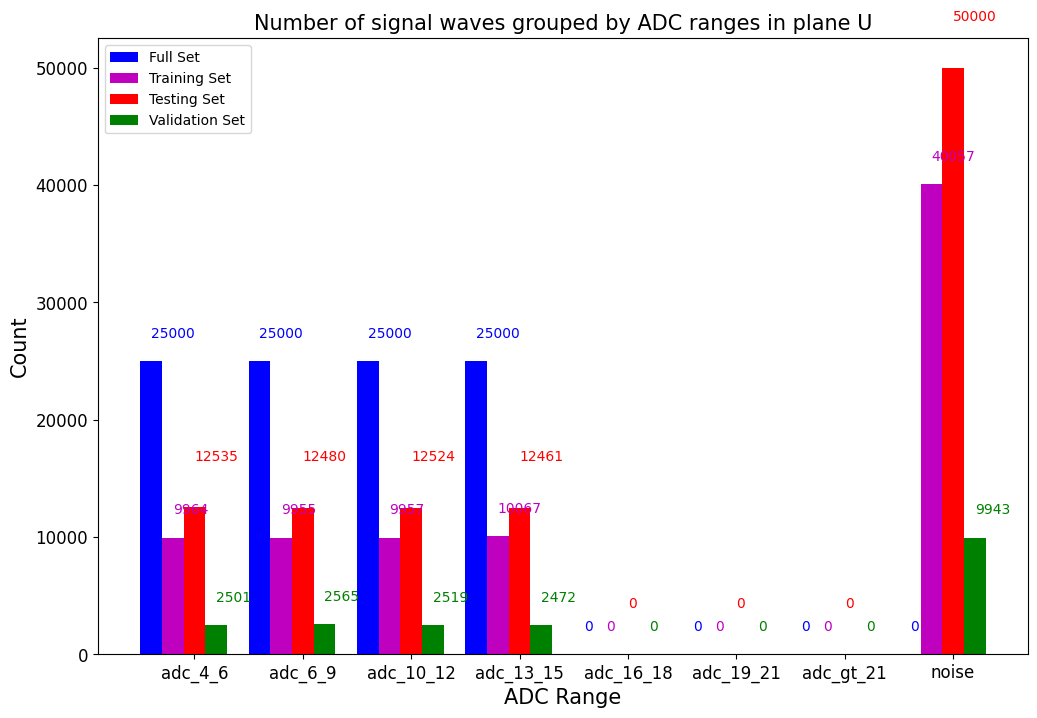

In [32]:
fig = plt.figure(figsize=(12,8))
plt.title('Number of signal waves grouped by ADC ranges in plane ' + wireplane, size=15)

x_labels = [pp.group_num_labels[i] for i in range(8)]
bar_width = 0.2

plt.bar([i - 2*bar_width for i in range(8)], dataset_to_train_small_adc_grouping[1], width=bar_width, color='blue', label='Full Set')
plt.bar([i - bar_width for i in range(8)], train_set[1], width=bar_width, color='m', label='Training Set')
plt.bar([i for i in range(8)], test_set[1], width=bar_width, color='r', label='Testing Set')
plt.bar([i + bar_width for i in range(8)], val_set[1], width=bar_width, color='green', label='Validation Set')

for i in range(8):
    dist = 2000
    plt.text(i - 2*bar_width, dataset_to_train_small_adc_grouping[1][i] + dist, dataset_to_train_small_adc_grouping[1][i], color='blue')
    plt.text(i - bar_width, train_set[1][i] + dist, train_set[1][i], color='m')
    plt.text(i, test_set[1][i] + 2*dist, test_set[1][i], color='r')
    plt.text(i + bar_width, val_set[1][i] + dist, val_set[1][i], color='g')


plt.xticks([i for i in range(8)], x_labels, size=12)
plt.yticks(size=12)
plt.legend()
plt.xlabel('ADC Range', size=15)
plt.ylabel('Count', size=15)
plt.show()

In [33]:
mean = x_train.mean()
std = x_train.std()

In [34]:
x_train_scaled = (x_train-mean)/std
x_test_scaled = (x_test-mean)/std
x_valid_scaled = (x_valid-mean)/std

y_train_scaled = (y_train-mean)/std
y_test_scaled = (y_test-mean)/std
y_valid_scaled = (y_valid-mean)/std

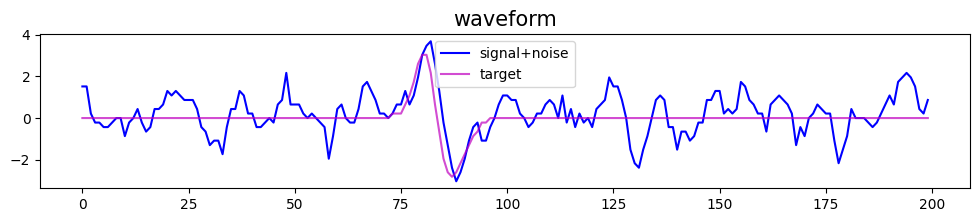

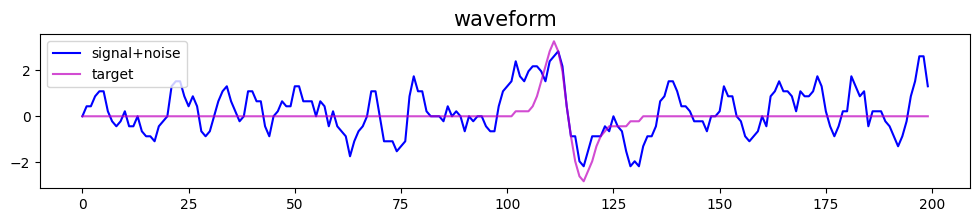

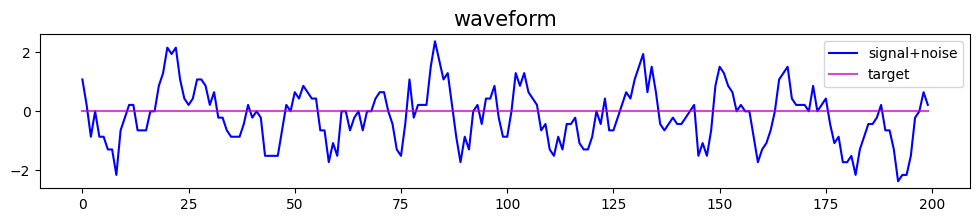

In [35]:
for idx in range(6,9):
    fig, (ax1) = plt.subplots(figsize=(12, 2), facecolor='white')
    ax1.plot(x_train_scaled[idx],color='blue', label='signal+noise')
    ax1.plot(y_train_scaled[idx],color='m',alpha=0.7, label='target')
    ax1.set_title("waveform", fontsize=15)
    ax1.legend()

    plt.show()

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dropout, Dense,Flatten, AveragePooling1D
from tensorflow.keras.layers import Input,  UpSampling1D
from tensorflow.keras.models import Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, \
    Dropout, Dense,Flatten, AveragePooling1D, BatchNormalization
#from keras import backend as K

In [37]:
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv1DTranspose

In [38]:
time_periods = 200
autoencoder = Sequential()
# encoder
autoencoder.add(Conv1D(filters=16, kernel_size=3, padding="same", strides=2, activation = "relu", input_shape=(time_periods,1)))
autoencoder.add(Conv1D(filters=32, kernel_size=5, padding="same", strides=4, activation = "relu"))
autoencoder.add(Conv1D(filters=64, kernel_size=9, padding="same", strides=5, activation = "relu"))

# decoder
autoencoder.add(Conv1DTranspose(filters=64, kernel_size=9, padding="same", strides=5, activation = "relu"))
autoencoder.add(Conv1DTranspose(filters=32, kernel_size=5, padding="same", strides=4, activation = "relu"))
autoencoder.add(Conv1DTranspose(filters=16, kernel_size=3, padding="same", strides=2, activation = "relu"))

autoencoder.add(Conv1DTranspose(filters=1, kernel_size=3, padding="same"))

autoencoder.compile(loss='mse', optimizer='adam')


2023-05-19 22:18:47.249717: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-19 22:18:47.380854: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-19 22:18:47.380924: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-19 22:18:47.384959: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-19 22:18:47.385029: I tensorflow/compile

In [39]:
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 16)           64        
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 32)            2592      
                                                                 
 conv1d_2 (Conv1D)           (None, 5, 64)             18496     
                                                                 
 conv1d_transpose (Conv1DTra  (None, 25, 64)           36928     
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 100, 32)          10272     
 ranspose)                                                       
                                                                 
 conv1d_transpose_2 (Conv1DT  (None, 200, 16)          1

In [40]:
for i,layer in enumerate(autoencoder.layers):                                      
  print(i,layer.name)

0 conv1d
1 conv1d_1
2 conv1d_2
3 conv1d_transpose
4 conv1d_transpose_1
5 conv1d_transpose_2
6 conv1d_transpose_3


In [41]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [42]:
batch_size_ = 2048

In [43]:
%%time
history = autoencoder.fit(x_train_scaled,                                                              
            y_train_scaled,                                                            
            batch_size=batch_size_,                                              
            epochs=1000,                                                      
            callbacks= [earlystop], #[NewCallback(alpha)], # callbacks=callbacks_list,
            validation_data=(x_valid_scaled, y_valid_scaled),                                                                      
            verbose=1)

2023-05-19 22:18:51.046308: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 64000000 exceeds 10% of free system memory.
2023-05-19 22:18:51.124272: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 64000000 exceeds 10% of free system memory.
2023-05-19 22:18:51.202710: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 64000000 exceeds 10% of free system memory.
2023-05-19 22:18:51.224714: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 64000000 exceeds 10% of free system memory.


Epoch 1/1000


2023-05-19 22:18:53.508995: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-19 22:18:54.962607: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-19 22:18:55.957161: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7ba0e000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-19 22:18:55.957196: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-05-19 22:18:56.025498: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-19 22:18:56.316584: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-19 22:18:56.401250: I ./tensorflow/compiler/jit/device_compiler

40/40 [==============================] - ETA: 0s - loss: 0.0856

2023-05-19 22:18:58.999744: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16000000 exceeds 10% of free system memory.


40/40 [==============================] - 9s 63ms/step - loss: 0.0856 - val_loss: 0.0684
Epoch 2/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.0516 - val_loss: 0.0404
Epoch 3/1000
40/40 [==============================] - 0s 12ms/step - loss: 0.0367 - val_loss: 0.0354
Epoch 4/1000
40/40 [==============================] - 0s 12ms/step - loss: 0.0336 - val_loss: 0.0333
Epoch 5/1000
40/40 [==============================] - 0s 12ms/step - loss: 0.0324 - val_loss: 0.0328
Epoch 6/1000
40/40 [==============================] - 0s 12ms/step - loss: 0.0319 - val_loss: 0.0323
Epoch 7/1000
40/40 [==============================] - 0s 12ms/step - loss: 0.0314 - val_loss: 0.0320
Epoch 8/1000
40/40 [==============================] - 1s 13ms/step - loss: 0.0310 - val_loss: 0.0317
Epoch 9/1000
40/40 [==============================] - 0s 12ms/step - loss: 0.0308 - val_loss: 0.0314
Epoch 10/1000
40/40 [==============================] - 0s 12ms/step - loss: 0.0306 - val_loss: 0.0314
Ep

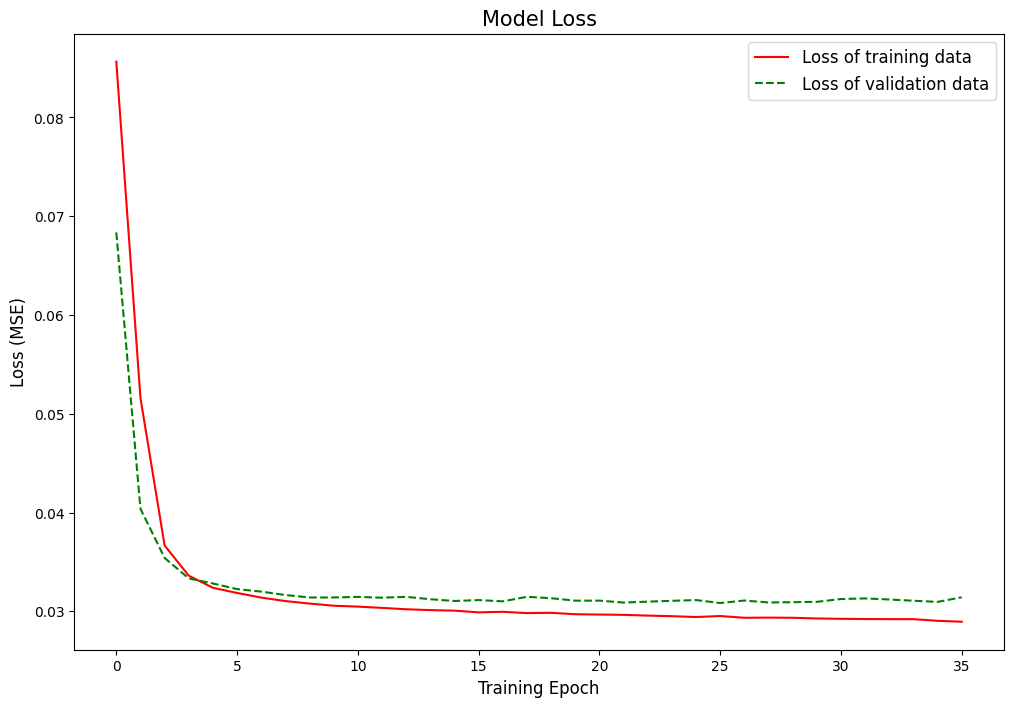

In [44]:
plt.figure(figsize=(12, 8))                                                     
plt.plot(history.history['loss'], "r", label="Loss of training data", antialiased=True)
plt.plot(history.history['val_loss'], "g--", label="Loss of validation data", antialiased=True)
plt.title('Model Loss',fontsize=15)                                            
plt.ylabel('Loss (MSE)', fontsize=12)                                                 
plt.xlabel('Training Epoch', fontsize=12)                                                                                                                       
plt.legend(fontsize=12)                                                                    
plt.show()     

In [45]:
#del x_train

import gc
gc.collect()

25395

In [46]:
#autoencoder.save('./models/model_AE_'+str(batch_size_)+'_no_pooling' + wireplane + 'plane_nu.h5')

In [47]:
#autoencoder = load_model('./models/model_AE_'+str(batch_size_)+'_no_pooling' + wireplane + 'plane_nu.h5')

In [48]:
autoencoder.evaluate(x_test_scaled, y_test_scaled, batch_size=4096)

25/25 [==============================] - 1s 16ms/step - loss: 0.0304


0.03042423538863659

In [49]:
autoencoder.evaluate(x_train_scaled, y_train_scaled, batch_size=4096)

20/20 [==============================] - 0s 19ms/step - loss: 0.0292


0.029224151745438576

In [50]:
autoencoder.evaluate(x_valid_scaled, y_valid_scaled, batch_size=4096)

5/5 [==============================] - 0s 70ms/step - loss: 0.0308


0.03084477223455906

In [51]:
#ae128 = load_model('./AE_models/model_AE_'+str(batch_size_)+'_mse' + wireplane + 'plane_nu.h5')

In [52]:
%%time
predictions = autoencoder.predict(x_test_scaled, batch_size=4096)
predictions = predictions.reshape(predictions.shape[0], predictions.shape[1])



25/25 [==============================] - 0s 7ms/step
CPU times: user 523 ms, sys: 239 ms, total: 762 ms
Wall time: 687 ms


In [53]:
from scipy import stats
x_test_ = std*x_test_scaled+mean
y_test_ = y_test_scaled*std + mean


pred = predictions*std + mean

In [54]:
# takes in prediction of AE and for every wave assigns 0 or 1
# 0 --> predicted as noise
# 1 --> pricicted as containing some kind of signals
# note that this is crude and does not consider how close the predicted signal is from truth
def label_predictions(ae_pred_wave):
    label_ = 0
    if max(abs(ae_pred_wave)) > 3:
        label_ = 1
    return label_


def label_truths(wave):
    label_ = 1
    if max(abs(wave)) <= 3:
        label_ = 0
    return label_

In [55]:
pred_labels = [label_predictions(wave) for wave in pred]
truth_labels = [label_truths(t_wave) for t_wave in y_test_]

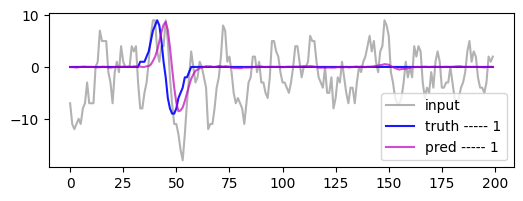

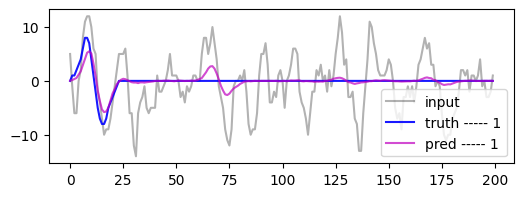

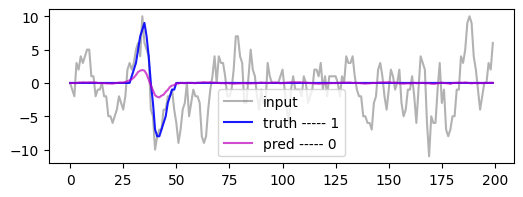

In [56]:
for i in range(100,115):
    if max(abs(y_test_[i])) < 10 and sum(abs(y_test_[i])) !=0:
        fig = plt.figure(figsize=(6,2))
        plt.plot(x_test_[i], color='black', alpha=0.3, label='input')
        plt.plot(y_test_[i], color='blue', alpha=0.9, label='truth ----- ' + str(truth_labels[i]))
        plt.plot(pred[i], color='m', alpha=0.7, label='pred ----- ' + str(pred_labels[i]))
        plt.legend()
        plt.show()


In [57]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(truth_labels, pred_labels, drop_intermediate=False)
roc_auc = auc(fpr, tpr)


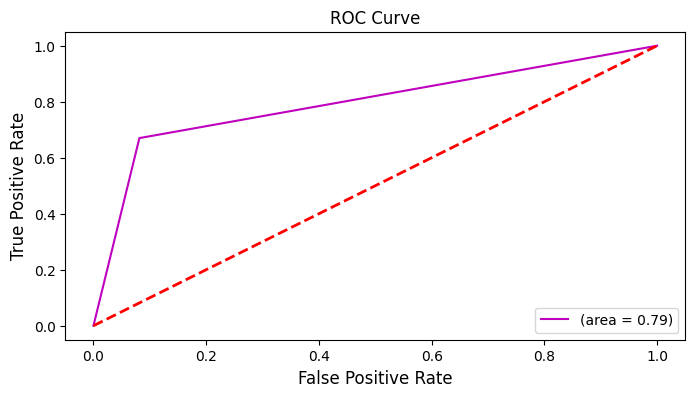

In [58]:
fig = plt.figure(figsize=(8, 4))
plt.plot(fpr, tpr, color='m', label='(area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2)
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', size=12)
plt.ylabel('True Positive Rate', size=12)
plt.title('ROC Curve', size=12)
plt.legend(loc="lower right")
plt.show()

In [59]:
# dataset_x -> noisy signal waveforms
# dataset_y -> clean signal waveforms
# splits data set into subsets based on ADC ranges
def adc_grouping(dataset_x, dataset_y, pred):
    adc_4_6_x = []
    adc_4_6_y = []
    adc_4_6_p = []

    adc_7_9_x = []
    adc_7_9_y = []
    adc_7_9_p = []

    adc_10_12_x = []
    adc_10_12_y = []
    adc_10_12_p = []

    adc_13_15_x = []
    adc_13_15_y = []
    adc_13_15_p = []

    adc_16_18_x = []
    adc_16_18_y = []
    adc_16_18_p = []

    adc_19_21_x = []
    adc_19_21_y = []
    adc_19_21_p = []

    adc_gt_21_x = []
    adc_gt_21_y = []
    adc_gt_21_p = []

    noise_x = []
    noise_y = []
    noise_p = []

    for i, wave in enumerate(dataset_y):
        if sum(abs(wave)) == 0:
            noise_x.append(x_test_[i])
            noise_y.append(wave)
            noise_p.append(pred[i])
            continue
        max_adc = max(abs(wave))
        if max_adc >= 4 and max_adc <= 6:
            adc_4_6_x.append(dataset_x[i])
            adc_4_6_y.append(wave)
            adc_4_6_p.append(pred[i])

        elif max_adc >= 7 and max_adc <=9:
            adc_7_9_x.append(dataset_x[i])
            adc_7_9_y.append(wave)
            adc_7_9_p.append(pred[i])
        elif max_adc >= 10 and max_adc <= 12:
            adc_10_12_x.append(dataset_x[i])
            adc_10_12_y.append(wave)
            adc_10_12_p.append(pred[i])
        elif max_adc >= 13 and max_adc <= 15:
            adc_13_15_x.append(dataset_x[i])
            adc_13_15_y.append(wave)
            adc_13_15_p.append(pred[i])
        elif max_adc >= 16 and max_adc <= 18:
            adc_16_18_x.append(dataset_x[i])
            adc_16_18_y.append(wave)
            adc_16_18_p.append(pred[i])
        elif max_adc >= 19 and max_adc <= 21:
            adc_19_21_x.append(dataset_x[i])
            adc_19_21_y.append(wave)
            adc_19_21_p.append(pred[i])
        else:
            adc_gt_21_x.append(dataset_x[i])
            adc_gt_21_y.append(wave)
            adc_gt_21_p.append(pred[i])

    grouped_waves = [
                    [adc_4_6_x, adc_4_6_y, adc_4_6_p],
                    [adc_7_9_x, adc_7_9_y, adc_7_9_p],
                    [adc_10_12_x, adc_10_12_y, adc_10_12_p],
                    [adc_13_15_x, adc_13_15_y, adc_13_15_p],
                    [adc_16_18_x, adc_16_18_y, adc_16_18_p],
                    [adc_19_21_x, adc_19_21_y, adc_19_21_p],
                    [adc_gt_21_x, adc_gt_21_y, adc_gt_21_p],
                    [noise_x, noise_y, noise_p]  
                    ]
    print(' 0: adc_4_6 \
            1: adc_7_9 \
            2: adc_10_12 \
            3: adc_13_15 \
            4: adc_16_18 \
            5: adc_19_21 \
            6: adc_gt_21\
            7: noise')
    print()
    

    return grouped_waves

group_num_labels = {
                    0: 'adc_4_6',
                    1: 'adc_6_9',
                    2: 'adc_10_12',
                    3: 'adc_13_15',
                    4: 'adc_16_18',
                    5: 'adc_19_21',
                    6: 'adc_gt_21',
                    7: 'noise'
                    }

# prints summary
def print_counts(data_x, data_y, pred):
    grouped = adc_grouping(data_x, data_y, pred)
    sum_ = 0
    
    res = []
    for i in range(8):
        count = len(grouped[i][0])
        print(group_num_labels[i])
        print('{:<12}{}'.format('count', count))
        print()
        res.append(count)
        if i < 7:
            sum_ += count

    print('{:<15}{}'.format('     signal:', sum_))
    print('{:<15}{}'.format('     noise:', len(grouped[7][0])))
    print('{:<15}{}'.format('     TOTAL', sum_+len(grouped[7][0])))

    return res

In [60]:
grouped_waves = adc_grouping(x_test_, y_test_, pred)

 0: adc_4_6             1: adc_7_9             2: adc_10_12             3: adc_13_15             4: adc_16_18             5: adc_19_21             6: adc_gt_21            7: noise



In [61]:
print_counts(x_test_, y_test_, pred)

 0: adc_4_6             1: adc_7_9             2: adc_10_12             3: adc_13_15             4: adc_16_18             5: adc_19_21             6: adc_gt_21            7: noise

adc_4_6
count       12535

adc_6_9
count       12480

adc_10_12
count       12524

adc_13_15
count       12461

adc_16_18
count       0

adc_19_21
count       0

adc_gt_21
count       0

noise
count       50000

     signal:   50000
     noise:    50000
     TOTAL     100000


[12535, 12480, 12524, 12461, 0, 0, 0, 50000]

In [62]:
len(grouped_waves[0][0])

12535

In [69]:
len(grouped_waves[0][2])

12535

In [70]:
def make_single_pdf(wave_idx, pg_num, group_num):

    fig, axs = plt.subplots(3,2, figsize=(20, 12), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .375, wspace=.1)

    axes = axs.ravel()

    for i in range(6):
        index_ = i + wave_idx
        wave_idx = index_


        axes[i].set_title('clean sig. +peak amplitude: ' + str(int(max(grouped_waves[group_num][1][index_]))),size=15)
        axes[i].plot(grouped_waves[group_num][0][index_], color='black', alpha=0.3, label='input')
        axes[i].plot(grouped_waves[group_num][1][index_], color='blue', alpha=0.9, label='truth')
        axes[i].plot(grouped_waves[group_num][2][index_], color='m', alpha=0.7, label='pred')
        axes[i].legend(fontsize=12)
    


    plt.savefig('./plots/tmp/tmp' +str(pg_num) + '.pdf',
                dpi=300,
                bbox_inches='tight', pad_inches=0.75)
    plt.close()

    return wave_idx

In [73]:
# creates and merges pdf, removes all single page pdfs from tmp folder
def make_complete_pdf(num_pages, group_num):
    wave_idx_ = 0
    page_num = 0

    while page_num < num_pages:
        wave_idx_ = make_single_pdf(wave_idx_, page_num, group_num) + 1
        page_num += 1

    merger = PdfMerger()
    path = './plots/tmp/'
    pdf_files = [path+f for f in listdir(path) if (isfile(join(path, f)))]
    print(pdf_files)
    for pdf_file in pdf_files:
        #Append PDF files
        merger.append(pdf_file)
    #merger.write('pdfs/plts_tmp/plts_' + wireplane + '_cnn_'+str(int(min_cnn*100)) + '-' + str(int(max_cnn*100)) + '_' + str(num_pages) +  'pages.pdf')
    merger.write('./plots/'+wireplane+'/plane_' + wireplane + '_' + group_num_labels[group_num] + '.pdf')
    merger.close()

    for file in pdf_files:
        os.remove(file)

In [74]:
for i in range(4):
    make_complete_pdf(15, i)

['./plots/tmp/tmp10.pdf', './plots/tmp/tmp8.pdf', './plots/tmp/tmp9.pdf', './plots/tmp/tmp12.pdf', './plots/tmp/tmp7.pdf', './plots/tmp/tmp4.pdf', './plots/tmp/tmp5.pdf', './plots/tmp/tmp1.pdf', './plots/tmp/tmp6.pdf', './plots/tmp/tmp13.pdf', './plots/tmp/tmp0.pdf', './plots/tmp/tmp3.pdf', './plots/tmp/tmp11.pdf', './plots/tmp/tmp2.pdf', './plots/tmp/tmp14.pdf']
['./plots/tmp/tmp10.pdf', './plots/tmp/tmp8.pdf', './plots/tmp/tmp9.pdf', './plots/tmp/tmp12.pdf', './plots/tmp/tmp7.pdf', './plots/tmp/tmp4.pdf', './plots/tmp/tmp5.pdf', './plots/tmp/tmp1.pdf', './plots/tmp/tmp6.pdf', './plots/tmp/tmp13.pdf', './plots/tmp/tmp0.pdf', './plots/tmp/tmp3.pdf', './plots/tmp/tmp11.pdf', './plots/tmp/tmp2.pdf', './plots/tmp/tmp14.pdf']
['./plots/tmp/tmp10.pdf', './plots/tmp/tmp8.pdf', './plots/tmp/tmp9.pdf', './plots/tmp/tmp12.pdf', './plots/tmp/tmp7.pdf', './plots/tmp/tmp4.pdf', './plots/tmp/tmp5.pdf', './plots/tmp/tmp1.pdf', './plots/tmp/tmp6.pdf', './plots/tmp/tmp13.pdf', './plots/tmp/tmp0.pdf', 

Rejection rate at each group

In [75]:
def eval_group(group_num):
    if group_num > 4:
        print('arg should be less than 6')
        return -1
    x = grouped_waves[group_num][0]
    y = grouped_waves[group_num][1]
    infer = grouped_waves[group_num][2]

    positive_x = []
    positive_y = []
    positive_p = []

    negative_x = []
    negative_y = []
    negative_p = []

    for i, wave in enumerate(infer):
        if max(abs(wave)) > 3:
            positive_x.append(x[i])
            positive_y.append(y[i])
            positive_p.append(wave)
        else:
            negative_x.append(x[i])
            negative_y.append(y[i])
            negative_p.append(wave)
    print(group_num_labels[group_num])
    print('{:<12}{}'.format('Total:', len(x)))
    print('{:<12}{}'.format('True Pos: ', len(positive_x)))
    print('{:<12}{}'.format('False Pos: ', len(negative_x)))
    print()

    return [[positive_x, positive_y, positive_p], [negative_x, negative_y, negative_p]]

In [76]:
for i in range(6):
    eval_group(i)

adc_4_6
Total:      12535
True Pos:   3730
False Pos:  8805

adc_6_9
Total:      12480
True Pos:   7076
False Pos:  5404

adc_10_12
Total:      12524
True Pos:   10650
False Pos:  1874

adc_13_15
Total:      12461
True Pos:   12049
False Pos:  412

adc_16_18
Total:      0
True Pos:   0
False Pos:  0

arg should be less than 6


In [77]:
len(grouped_waves)

8

In [78]:
noise_p = grouped_waves[7][2]

In [79]:
noise__ = [max(abs(wave)) for wave in noise_p if max(abs(wave)) > 3]

In [80]:
print('{:<12}{}'.format('Total:', len(grouped_waves[7][0])))
print('{:<12}{}'.format('True Neg: ', len(grouped_waves[7][0]) - len(noise__)))
print('{:<12}{}'.format('False Neg: ', len(noise__)))
print()

Total:      50000
True Neg:   45925
False Neg:  4075



In [81]:
grouped_pred_waves = adc_grouping(pred, y_test, pred)

 0: adc_4_6             1: adc_7_9             2: adc_10_12             3: adc_13_15             4: adc_16_18             5: adc_19_21             6: adc_gt_21            7: noise



In [82]:
def get_num_TP(group_num):
    if group_num > 6:
        print('arg should be less than 6')
        return -1
    y = grouped_pred_waves[group_num][1]
    infer = grouped_pred_waves[group_num][0]

    positive_y = []
    positive_p = []

    negative_y = []
    negative_p = []

    for i, wave in enumerate(infer):
        if max(abs(wave)) > 3:
            positive_y.append(y[i])
            positive_p.append(wave)
        else:
            negative_y.append(y[i])
            negative_p.append(wave)
    print(group_num_labels[group_num])
    print('{:<12}{}'.format('Total:', len(y)))
    print('{:<12}{}'.format('True Pos: ', len(positive_y)))
    print('{:<12}{}'.format('False Pos: ', len(negative_y)))
    print()

    return len(positive_y)

In [83]:
test_set_TP = []
for i in range(7):
    test_set_TP.append(get_num_TP(i))
    

adc_4_6
Total:      12535
True Pos:   3730
False Pos:  8805

adc_6_9
Total:      12480
True Pos:   7076
False Pos:  5404

adc_10_12
Total:      12524
True Pos:   10650
False Pos:  1874

adc_13_15
Total:      12461
True Pos:   12049
False Pos:  412

adc_16_18
Total:      0
True Pos:   0
False Pos:  0

adc_19_21
Total:      0
True Pos:   0
False Pos:  0

adc_gt_21
Total:      0
True Pos:   0
False Pos:  0



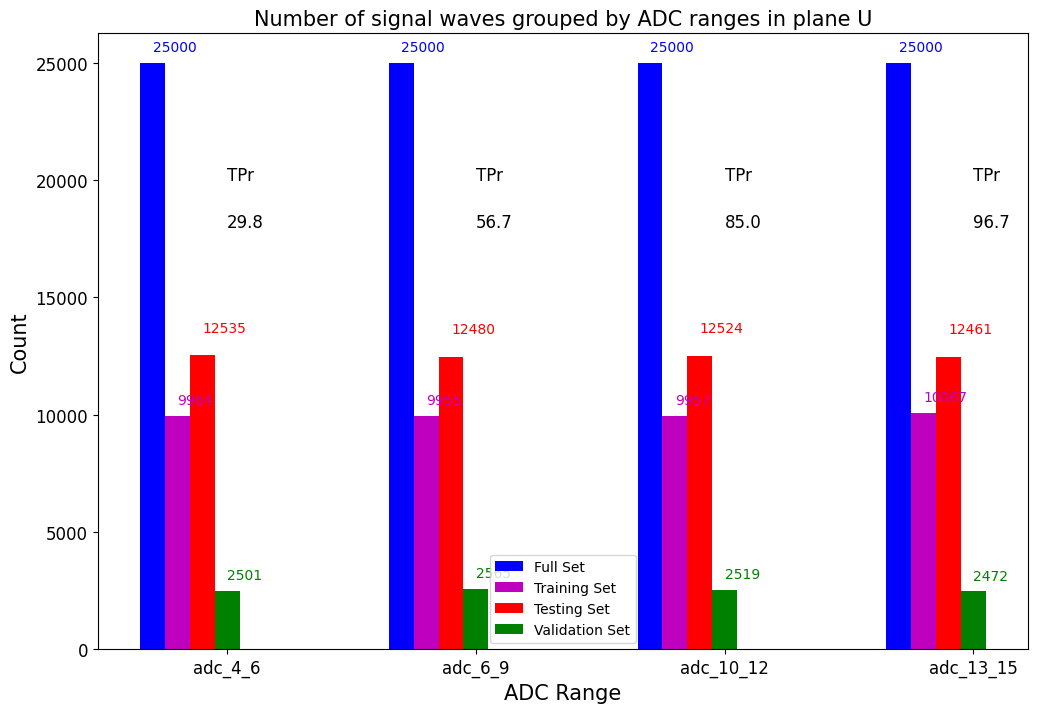

In [84]:
fig = plt.figure(figsize=(12,8))
num_x = 4
plt.title('Number of signal waves grouped by ADC ranges in plane ' + wireplane, size=15)

x_labels = [group_num_labels[i] for i in range(num_x)]
bar_width = 0.1

plt.bar([i - 2*bar_width for i in range(num_x)], dataset_to_train_small_adc_grouping[1][:num_x], width=bar_width, color='blue', label='Full Set')
plt.bar([i - bar_width for i in range(num_x)], train_set[1][:num_x], width=bar_width, color='m', label='Training Set')
plt.bar([i for i in range(num_x)], test_set[1][:num_x], width=bar_width, color='r', label='Testing Set')
plt.bar([i + bar_width for i in range(num_x)], val_set[1][:num_x], width=bar_width, color='green', label='Validation Set')

for i in range(num_x):
    dist = 500
    plt.text(i - 2*bar_width, dataset_to_train_small_adc_grouping[1][i] + dist, dataset_to_train_small_adc_grouping[1][i], color='blue')
    plt.text(i - bar_width, train_set[1][i] + dist, train_set[1][i], color='m')
    plt.text(i, test_set[1][i] + 2*dist, test_set[1][i], color='r')
    plt.text(i + bar_width, val_set[1][i] + dist, val_set[1][i], color='g')

    plt.text(i+bar_width, 20000, 'TPr', size=12)
    plt.text(i+bar_width, 18000, round((test_set_TP[i]/test_set[1][i])*100, 1), size=12)

    #plt.text(1, 17000, 'TPrs are for the testing set', size=12)

plt.xticks([i+bar_width for i in range(num_x)], x_labels, size=12)
plt.yticks(size=12)
plt.legend()
plt.xlabel('ADC Range', size=15)
plt.ylabel('Count', size=15)
plt.show()